In [110]:
import pandas as pd
#import evaluate
import numpy as np
#from datasets import Dataset
#from transformers import AutoTokenizer, AutoModelForMaskedLM, DataCollatorWithPadding, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.model_selection import train_test_split
from transformers import TFDistilBertForSequenceClassification, DistilBertTokenizer
import tensorflow as tf
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ROB7824\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ROB7824\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [91]:
text_df = pd.read_csv("./df_file.csv") #./df_file.csv, /content/drive/MyDrive/df_file.csv

X = text_df['Text'].to_list()
y = text_df['Label'].to_list()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [94]:
X_train_W2C = pd.DataFrame(X_train, columns=['Text'])

cnt = Counter()
for text in X_train_W2C['Text'].values:
    for word in text.split():
        cnt[word] += 1
        
cnt.most_common(20)

[('the', 35701),
 ('to', 19858),
 ('of', 15861),
 ('and', 14387),
 ('a', 13698),
 ('in', 13238),
 ('for', 6883),
 ('is', 6792),
 ('that', 6058),
 ('on', 5815),
 ('The', 5721),
 ('was', 4810),
 ('be', 4604),
 ('with', 4096),
 ('said', 3939),
 ('has', 3889),
 ('it', 3875),
 ('have', 3812),
 ('as', 3671),
 ('will', 3528)]

In [85]:
from collections import Counter
cnt = Counter()
for text in X_train['Text'].values:
    for word in text.split():
        cnt[word] += 1
        
cnt.most_common(10)

[('said', 5855),
 ('mr', 2421),
 ('year', 2316),
 ('would', 2122),
 ('also', 1758),
 ('peopl', 1685),
 ('new', 1606),
 ('us', 1530),
 ('one', 1452),
 ('game', 1335)]

In [95]:
#https://medium.com/@kiddojazz/distilbert-for-multiclass-text-classification-using-transformers-d6374e6678ba
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

#Add lemmatization
def preprocess_text(text):
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Replace multiple whitespaces with a single space
    text = re.sub(r'\s+', ' ', text)
    
    # Remove leading and trailing whitespaces
    text = text.strip()

    # Lowercasing
    text = text.lower()
    
    # Removing punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Tokenization with NLTK
    tokens = word_tokenize(text)

    # Removing stop words
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words and word not in tokenizer.all_special_tokens]

    # Stemming
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(word) for word in filtered_tokens]
    
    # Joining tokens
    text = ' '.join(stemmed_tokens)

    # Tokenization with DistilBert
    text = tokenizer(text, truncation=True, padding=True)
    #text = tf.data.Dataset.from_tensor_slices((dict(encoded_input), y_train))

    return text


# Example usage
X_train = [preprocess_text(text) for text in X_train]
X_test = [preprocess_text(text) for text in X_test]

## Most frequent N-grams

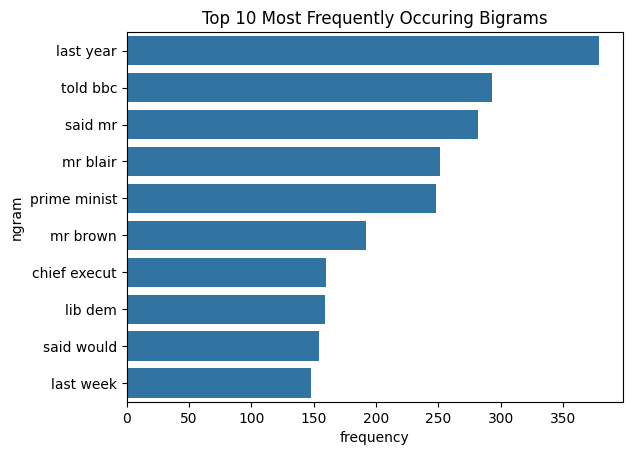

In [111]:
# Decoding Tokenized Text
decoded_texts = [tokenizer.decode(entry['input_ids'], skip_special_tokens=True) for entry in X_train]
readable_text = pd.DataFrame(decoded_texts, columns=['Text'])

# Checking most frequent Bi-grams
cv2 = CountVectorizer(ngram_range=(2,2))
bigrams = cv2.fit_transform(readable_text['Text'])

count_values = bigrams.toarray().sum(axis=0)
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv2.vocabulary_.items()], reverse = True))
ngram_freq.columns = ["frequency", "ngram"]

sns.barplot(x=ngram_freq['frequency'][:10], y=ngram_freq['ngram'][:10])
plt.title('Top 10 Most Frequently Occuring Bigrams')
plt.show()

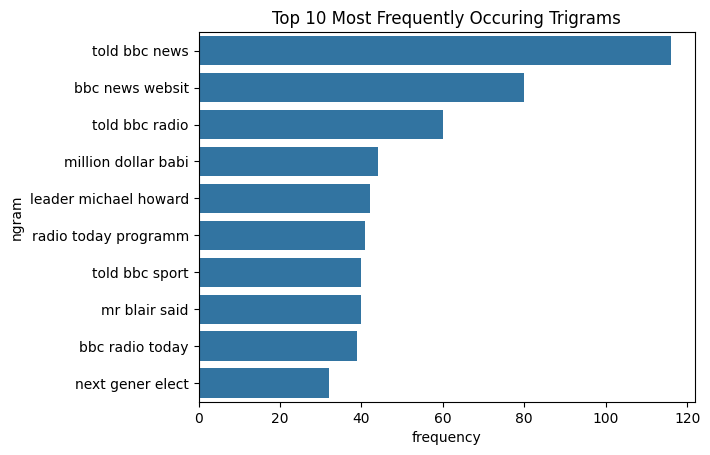

In [113]:
# Checking most frequent Tri-grams
cv3 = CountVectorizer(ngram_range=(3,3))
trigrams  = cv3.fit_transform(readable_text['Text'])

count_values = trigrams .toarray().sum(axis=0)
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv3.vocabulary_.items()], reverse = True))
ngram_freq.columns = ["frequency", "ngram"]

sns.barplot(x=ngram_freq['frequency'][:10], y=ngram_freq['ngram'][:10])
plt.title('Top 10 Most Frequently Occuring Trigrams')
plt.show()

In [47]:
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=5)
 
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5, epsilon=1e-08)
model.compile(optimizer=optimizer, loss=model.hf_compute_loss, metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
 
model.fit(train_dataset.shuffle(1000).batch(16),
epochs=2,
batch_size=16,
#validation_data=val_dataset.shuffle(1000).batch(16),
callbacks=[early_stopping])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/2


  1/112 [..............................] - ETA: 1:29:07 - loss: 1.6219 - accuracy: 0.1250

KeyboardInterrupt: 

In [10]:
from tensorflow.keras.models import load_model
save_directory = "Models"
 
model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

('Models\\tokenizer_config.json',
 'Models\\special_tokens_map.json',
 'Models\\vocab.txt',
 'Models\\added_tokens.json')

In [11]:
loaded_tokenizer = DistilBertTokenizer.from_pretrained(save_directory)
loaded_model = TFDistilBertForSequenceClassification.from_pretrained(save_directory)

Some layers from the model checkpoint at Models were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at Models and are newly initialized: ['dropout_39']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [61]:
# Assuming X_test is a dictionary with 'input_ids' key
readable_text = tokenizer.decode(X_test[10]['input_ids'], skip_special_tokens=True)
print(readable_text)


blunkett row end blair prime minist toni blair said time draw line controversi surround david blunkett tori lib dem call second inquiri fasttrack visa applic mr blunkett exlov nanni sir alan budd found chain event link mr blunkett leoncia casalm indefinit leav remain applic end middl east trip mr blair said still admir mr blunkett thought integr intact tuesday sir alan said applic leav remain uk made kimberli quinn nanni process day day faster averag could find evid show whether mr blunkett intervent intend give special help lover nanni rais case exampl poor department perform first comment sinc sir alan announc mr blair told bbc news yet read report detail told bbc news far im concern drawn line ask mr blunkett could return frontlin polit point repli made admir david clear remain he tremend colleagu he done great job us first home secretari educ secretari futur someth approach futur prime minist shrug claim conserv leader michael howard led grubbi govern said mr blunkett integr remain

In [20]:
def predict_category(text):
        predict_input = loaded_tokenizer.encode(text, truncation=True, padding=True, return_tensors="tf")
        output = loaded_model(predict_input)[0]
        prediction_value = tf.argmax(output, axis=1).numpy()[0]
        return prediction_value

In [21]:
y_pred = []
for text_ in X_test:
    y_pred.append(predict_category(text_))

In [25]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on Test Set:", accuracy)

# Additional evaluation metrics (classification report)
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy on Test Set: 0.9752808988764045
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98        92
           1       1.00      0.98      0.99        98
           2       0.97      0.96      0.97        77
           3       0.95      1.00      0.97        76
           4       0.96      0.96      0.96       102

    accuracy                           0.98       445
   macro avg       0.97      0.98      0.98       445
weighted avg       0.98      0.98      0.98       445



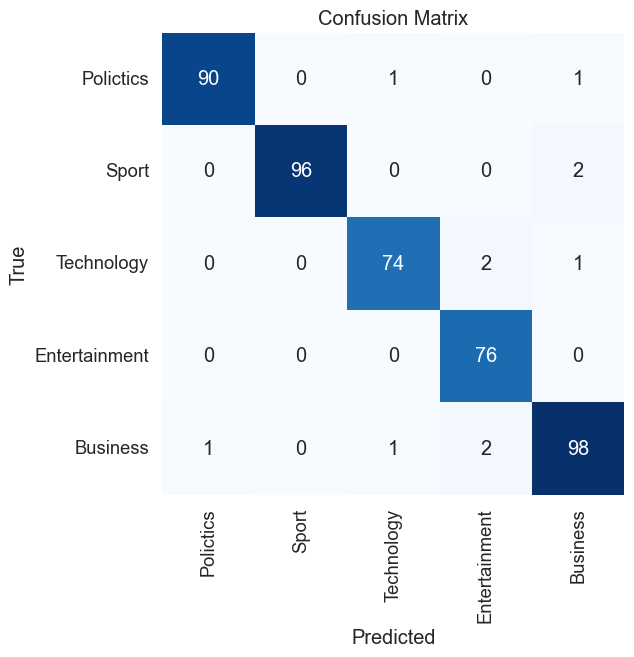

In [24]:
confusion = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False, square=True,
xticklabels=["Polictics", "Sport", "Technology", "Entertainment", "Business"], yticklabels=["Polictics", "Sport", "Technology", "Entertainment", "Business"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()